# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics

!pip install opencv-python 
import cv2
import gc
import os
 
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
 
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable



# Importing Dataset


In [3]:
import zipfile
 
data_path = (r'C:\Users\shrik\OneDrive\Desktop\SS\Project\ML\Object Detection CNN.zip')
 
with zipfile.ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [4]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

# Data Visualization

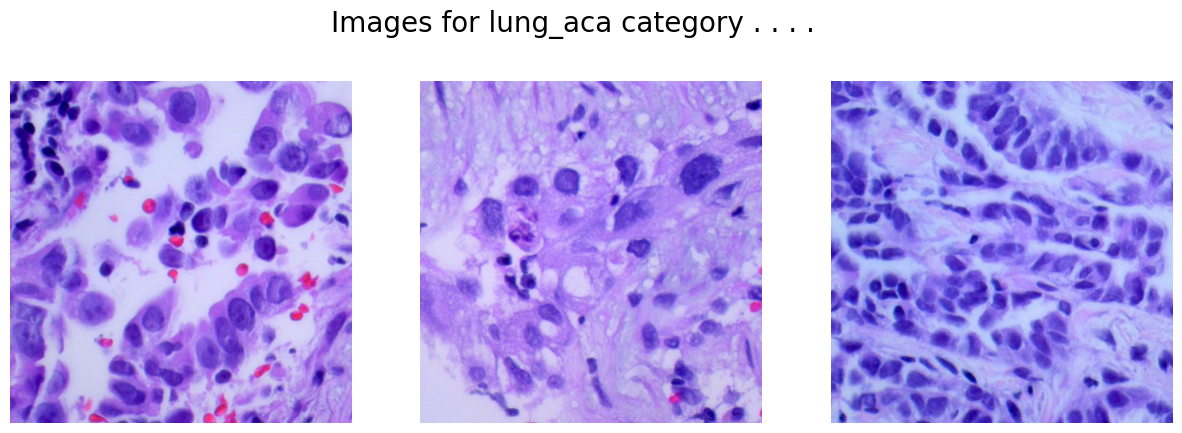

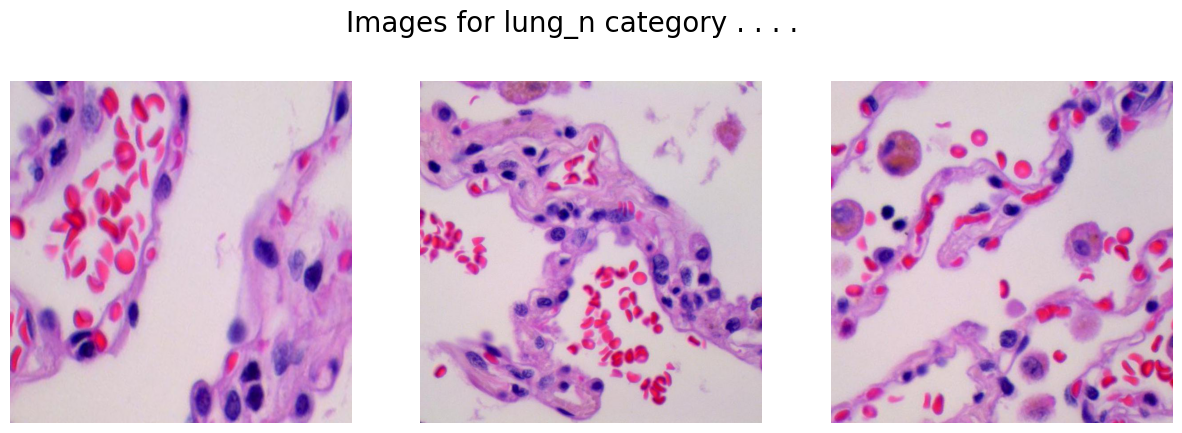

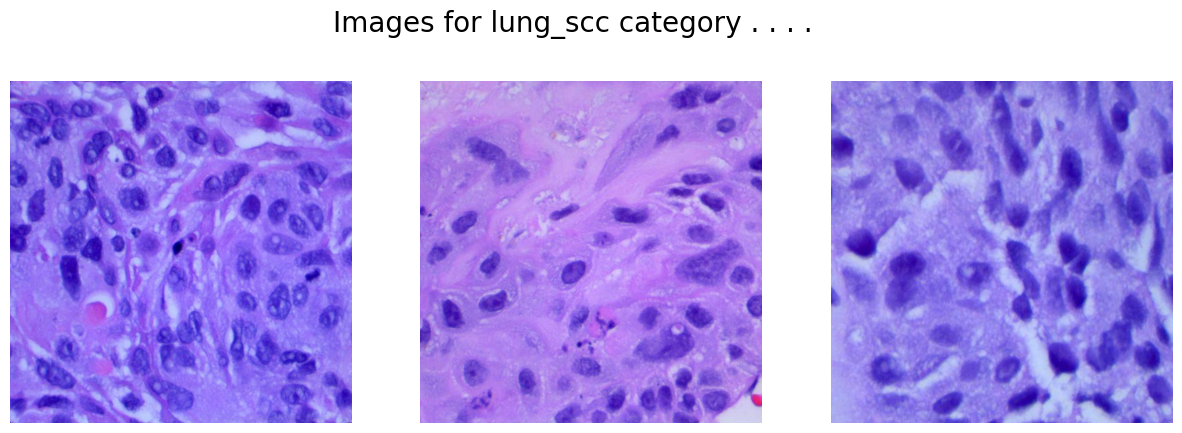

In [5]:
path = 'lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# Data Preparation for Training

In [6]:
X = []
Y = []
 
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (256, 256)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, one_hot_encoded_Y,test_size = 0.2,random_state = 2022)

print(X_train.shape, X_test.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [8]:
print(Y_train.shape, Y_test.shape)

(12000, 3) (3000, 3)


# Model Development

In [9]:
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5),activation='relu',input_shape=(256,256,3),padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [11]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss', patience=2,factor=0.5, verbose=1)

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = 64, epochs = 10,
                    verbose = 1,callbacks = [es, lr])

Epoch 1/10


188/188 [==============================] - 1432s 8s/step - loss: 0.3808 - accuracy: 0.8395 - val_loss: 12.6473 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 992s 5s/step - loss: 0.2412 - accuracy: 0.9047 - val_loss: 1.4921 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 550s 3s/step - loss: 0.1964 - accuracy: 0.9208 - val_loss: 0.6349 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 489s 3s/step - loss: 0.1401 - accuracy: 0.9434 - val_loss: 0.5479 - val_accuracy: 0.7903 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 487s 3s/step - loss: 0.1181 - accuracy: 0.9567 - val_loss: 0.5298 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 494s 3s/step - loss: 0.1020 - accuracy: 0.9618 - val_loss: 0.3176 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - 472s 3

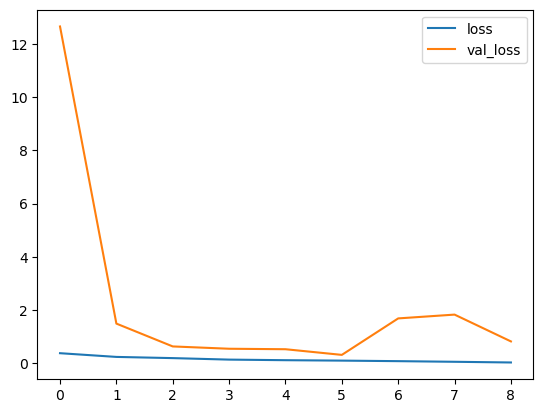

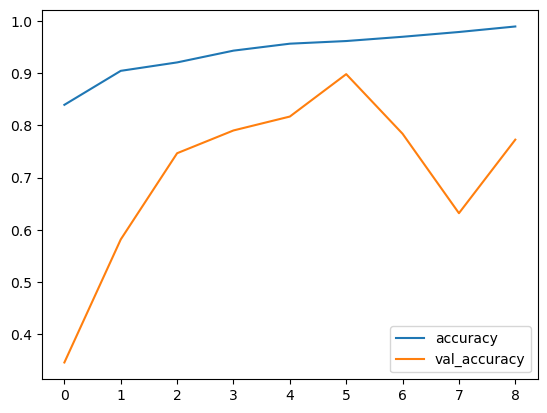

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# Model Evaluation

In [14]:
Y_pred = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 28s 283ms/step


In [15]:
metrics.confusion_matrix(Y_test, Y_pred)

array([[872,   6, 109],
       [ 11, 966,   0],
       [179,   0, 857]], dtype=int64)

In [16]:
print(metrics.classification_report(Y_test, Y_pred,target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.82      0.88      0.85       987
      lung_n       0.99      0.99      0.99       977
    lung_scc       0.89      0.83      0.86      1036

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

